<br>

# <font color="#76b900" style="text-align:center;">Embedding Models and Semantic Reasoning</font>


- Learn how to apply these embedding models in large-scale document processing, enhancing our existing methods of document summarization and knowledge extraction.


### **Environment Setup:**

In [ ]:
%pip install -qq langchain langchain-nvidia-ai-endpoints gradio
%pip install -qq arxiv pymupdf

import os
os.environ["NVIDIA_API_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxxxxxx"

from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

----

<br>

## Using An NVIDIAEmbeddings Model

### **Identifying Our Model**

Among your available models, you should find an embedding model suitable for discriminating between human-readable passages. After identifying the endpoint of interest, create an `NVIDIAEmbeddings` instance that will connect to it and see what methods it provides.


In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

[m for m in NVIDIAEmbeddings.get_available_models() if "embed" in m.id]

[Model(id='nvidia/embed-qa-4', model_type='embedding'),
 Model(id='nvidia/nv-embed-v1', model_type='embedding'),
 Model(id='nvidia/nv-embedqa-e5-v5', model_type='embedding'),
 Model(id='nvidia/nv-embedqa-mistral-7b-v2', model_type='embedding'),
 Model(id='snowflake/arctic-embed-l', model_type='embedding')]

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

# NVIDIAEmbeddings.get_available_models()
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-mistral-7b-v2")
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")
# embedder = NVIDIAEmbeddings(model="nvidia/embed-qa-4")
# embedder = NVIDIAEmbeddings(model="snowflake/arctic-embed-l")
embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")


#### **Exploration with Example "Queries" and "Documents"**

Let's consider a set of example queries and documents to kickstart our exploration and understand these processes in action. These examples are carefully selected to highlight interesting properties and showcase our embedding model's capabilities for general text reasoning.


In [ ]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]

We can encode these passages via either the query or the document pathways. Since the method signatures differ due to their intended use cases, the syntax will be a bit different between the two options:


In [ ]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: user 121 ms, sys: 4.08 ms, total: 126 ms
Wall time: 10.8 s


With our embeddings in hand, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task. When your entries are ready, run the following code block to visualize the cross-similarity matrix.

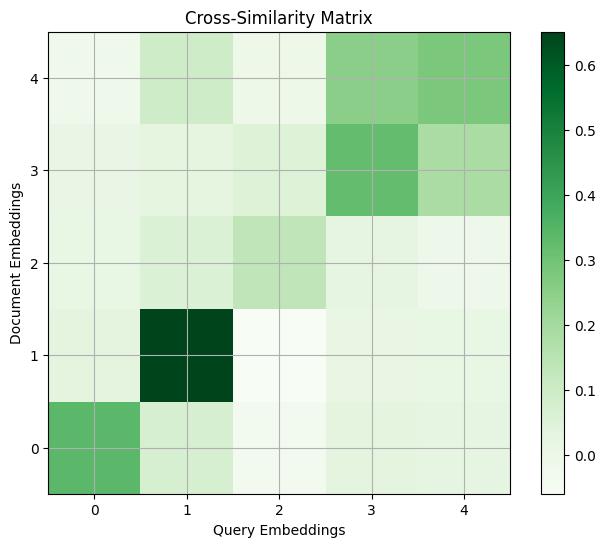

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):
    # Compute the similarity matrix between embeddings1 and embeddings2
    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings)
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

# queries = [
#     "What's the weather like in the Rocky Mountains?",
#     "What kinds of food is Italy known for?",
#     "What's my name? I bet you don't remember...",
#     "What's the point of life anyways?",
#     "The point of life is to have fun :D"]
# documents = [
#     "Komchatka's weather is cold, with long, severe winters.",
#     "Italy is famous for pasta, pizza, gelato, and espresso.",
#     "I can't recall personal names, only provide information.",
#     "Life's purpose varies, often seen as personal fulfillment.",
#     "Enjoying life's moments is indeed a wonderful approach."]

----

<br>

## A Synthetic - But More Realistic - Example

Observe that the entries that could be perceived as good input/output pairs trigger relatively high similarity on embedding. It is worth mentioning that, depending on the encoder model convergence, the query and document pathway may or may not be significantly different:


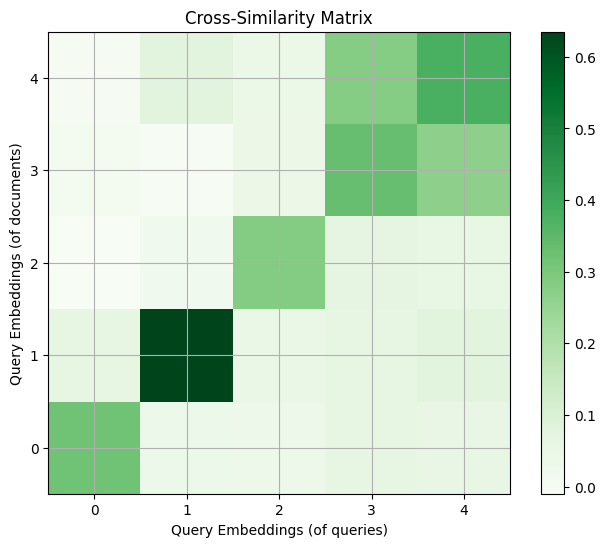

In [ ]:
plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(
    q_embeddings,
    [embedder.embed_query(doc) for doc in documents]
)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of documents)")
plt.show()

The real utility of having a "bi-encoder" **in general** is that the second encoder can be trained to remain consistent with the first even if the format of the input starts deviating drastically. To help illustrate this, we can flesh out our documents into longer-form variations and try the same experiment again.

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

expound_prompt = ChatPromptTemplate.from_template(
    "Generate part of a longer story that could reasonably answer all"
    " of these questions somewhere in its contents: {questions}\n"
    " Make sure the passage only answers the following concretely: {q1}."
    " Give it some weird formatting, and try not to answer the others."
    " Do not include any commentary like 'Here is your response'"
)

expound_chain = (
    {'q1' : itemgetter(0), 'questions' : itemgetter(1)}
    | expound_prompt
    | instruct_llm
    | StrOutputParser()
)

longer_docs = []
for i, q in enumerate(queries):
    longer_doc = ""
    longer_doc = expound_chain.invoke([q, queries])
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-"*64)
    longer_docs += [longer_doc]


[Query 1]

What's the weather like in Rocky Mountains?


[Document 1]

Weather in the Rocky Mountains can be as unpredictable as a cat on a hot tin roof. One minute, the sun is shining bright, casting a golden glow on the rugged peaks, and the next, a thunderstorm rolls in, unleashing a torrent of rain and hail. But let's not forget about winter, when the mountains transform into a winter wonderland, with snowflakes as big as your face and winds that can knock you off your feet. Ah, the magic of the Rocky Mountains - where the weather is as varied as the landscapes themselves.

(Meanwhile, in another part of the story)
"So, what's my name? I bet you don't remember..." the young woman said, trying to hide a smirk.
"Oh, I remember plenty of things," the fortune teller replied cryptically, avoiding the question.

(And in yet another part)
The group sat around the dinner table, indulging in the fruits of Italy's labor. Plates piled high with pasta, pizza, and gelato brought smiles to their faces. But amidst the food-filled revelry, one question still lingered

----------------------------------------------------------------

[Query 2]

What kinds of food is Italy known for?


[Document 2]

**Random Musings**

As I sat pondering the meaning of life, my mind began to wander. I thought about the majestic Rocky Mountains and their ever-changing weather, but I quickly brushed that thought aside. I then considered the question of my identity, of what my name might be, but that too seemed trivial in the grand scheme of things. No, what really intrigued me was the question of the purpose of life. Was it simply to have fun, as some would have me believe? These questions were fascinating, but they would have to wait for another time.

For now, I needed to focus on the task at hand. I had been asked about the kinds of food that Italy is known for, and I was determined to give a worthy answer. After all, food is one of life's greatest pleasures, and Italy has so much to offer in this regard.

Italian cuisine is renowned for its simplicity, yet it is anything but boring. From the creamy risottos of the north to the zesty pastas of the south, there is something for everyone. And let's

----------------------------------------------------------------

[Query 3]

What's my name? I bet you don't remember...


[Document 3]

"By the way," it said, almost as an afterthought, "you asked who I am. I think you wanted to know my name. It's peculiar that you would forget, after all we've been through. But then again, you always were a bit forgetful. Anyways, I digress. My name is **Az832**. Quirky, isn't it? I came up with it myself."


----------------------------------------------------------------

[Query 4]

What's the point of life anyways?


[Document 4]

In the vast expanse of the cosmos, amidst spiraling galaxies and twinkling stars, there exists a tiny blue planet known as Earth. On this wondrous orb, there are innumerable mysteries and wonders, from the deepest oceans to the loftiest peaks. The point of life, some philosophers say, lies in the exploration and experience of these wonders.

Consider the majestic Rocky Mountains, stretching over 3,000 miles across North America, their peaks often obscured by the swirling clouds that carry life-giving rain and snow. Each year, countless adventurers flock to these towering heights, testing their strength and endurance against the raw power of nature. To some, ascending the tallest peaks and feeling the crisp mountain air on their faces is the very essence of life, a reminder of the delicate balance between human ambition and the force of the natural world.

Yet, life is not solely the providence of humans or the terrain they inhabit. A world away, in the sun-drenched country of Italy, th

----------------------------------------------------------------

[Query 5]

The point of life is to have fun :D


[Document 5]

**the.point.of.life.is.to.have.fun.:**

*have you ever wondered about the purpose of existence, the reason we are all here, the *true* meaning of life? well, my dear friend, the answer is simple: the point of life is to have fun :D*

*it's true! life is too short to be serious all the time. we must take time to enjoy the little things, like a warm summer day in the rocky mountains, the taste of authentic italian pasta, or the sound of laughter with friends.*

*so go ahead, my friend, and have fun! because that's what life is all about :D*


----------------------------------------------------------------

-----

To see how the embeddings compare. The results may be similar, but there is at least some mathematically-optimized relationship that might help improve retrieval results at a larger scale. This result will also vary depending on the bi-encoder model, so keep that in mind.

In general, it's a good idea to default towards using the opposite encoder for its advertised use case and gravitate closer towards using the same encoder when you assume that the things you're comparing are similar in form and modality. To be clear, the deviation for the model we tested was only slightly different between the two options, but it's still a consideration to make.


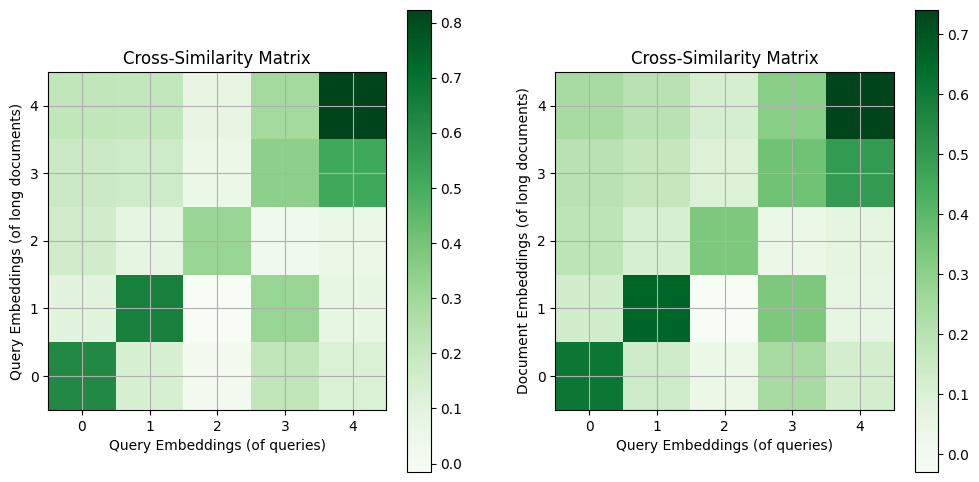

In [ ]:
## At the time of writing, our embedding model supports up to 2048 tokens...
longer_docs_cut = [doc[:2048] for doc in longer_docs]

q_long_embs = [embedder._embed([doc], model_type='query')[0] for doc in longer_docs_cut]
d_long_embs = [embedder._embed([doc], model_type='passage')[0] for doc in longer_docs_cut]

## The difference for any particular example may be very small.
## We've raised the similarity matrix to the power of 5 to try and spot a difference.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_cross_similarity_matrix(q_embeddings, q_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of long documents)")

plt.subplot(1, 2, 2)
plot_cross_similarity_matrix(q_embeddings, d_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Document Embeddings (of long documents)")
plt.show()